In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu0"
os.environ["CPATH"] = ""
import numpy as np

from collections import OrderedDict
from lasagnekit.misc.draw_net import draw_to_notebook, draw_to_file
from lasagnekit.misc.plot_weights import grid_plot
from lasagnekit.misc.dream import build_dreamer
from lasagnekit.easy import LightweightModel, BatchOptimizer
from lasagnekit.generative.capsule import Capsule
from lasagnekit.easy import BatchIterator, get_batch_slice


from lasagnekit.datasets.mnist import MNIST
from lasagnekit.datasets.fonts import Fonts
from lasagnekit.datasets.rescaled import Rescaled
from lasagnekit.datasets.dtd import DTD
from lasagnekit.datasets.cached import Cached
from lasagnekit.datasets.faces import Faces
from lasagnekit.datasets.cifar100 import Cifar100

from lasagnekit.misc.plot_weights import grid_plot
from lasagne import layers, updates
from IPython.display import SVG

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


srng = RandomStreams(seed=234)


from skimage.io import imread
from skimage.transform import resize

from lasagnekit.easy import get_stat

import matplotlib.pyplot as plt

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.init import GlorotUniform, Constant
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

from utils import TransposedConv2DLayer, Conv2DDenseLayer, TransposedDenseLayer, SampleOutLayer

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: Tesla K20Xm (CNMeM is disabled)


In [2]:
seed = 1234
np.random.seed(seed)
rng = RandomStreams(seed)

In [3]:
# choose between mnist and fonts
dataset = "mnist"
w, h = 28, 28 # Desired resolution, not necessarely the same than real_w and real_h, 
              # if necessary the images will be resize to fit w and h)

In [4]:
if dataset == "mnist":
    data = MNIST()
elif dataset == "fonts":
    data = Fonts(kind="all_64", 
                 labels_kind="letters")
elif dataset == "textures":
    data = DTD(examples_filter=np.arange(2000))
    data.load()
elif dataset == "cifar":
    data = Cifar100()
    
data_rescaled = Cached(Rescaled(data, size=(w, h)))
data_rescaled.load()
X = data_rescaled.X
if hasattr(data_rescaled, "y"):
    y = data_rescaled.y
else:
    y = np.ones((X.shape[0],))

In [5]:
if len(data_rescaled.img_dim) == 3:
    nb_colors = data_rescaled.img_dim[0]
else:
    nb_colors = 1 # gray

In [6]:
extract_patches = False
if extract_patches:
    from sklearn.feature_extraction.image import PatchExtractor
    w, h = 12, 12
    extractor = PatchExtractor(max_patches=100, patch_size=(w, h))
    patches = extractor.transform(X.reshape((X.shape[0], nb_colors, w, h)).transpose((0, 2, 3, 1)))
    patches = patches.transpose((0, 3, 1, 2))
    X = patches.astype(np.float32)
    y = np.ones((X.shape[0]))


In [7]:
print(X.shape, y.shape,)
flat_shape = X.shape

((70000, 784), (70000,))


In [8]:
standardize=False
if standardize is True:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    def preprocess(X):
        return scaler.transform(X.reshape((X.shape[0], -1)))
    def deprocess(X_p):
        return scaler.inverse_transform(X_p).reshape((X_p.shape[0], nb_colors, w, h))
else:
    class Dummy(object): pass
    scaler = Dummy()
    scaler.transform = lambda x:x
    scaler.inverse_transform = lambda x:x
    def preprocess(X):
        return X
    def deprocess(X_p):
        return X_p

In [9]:
X = X.reshape((X.shape[0], nb_colors, w, h))
image_shape = X.shape

In [10]:
zca = False
if zca is True:
    assert standardize is True
    zca = ZCA()
    X = zca.fit_transform(X.reshape((X.shape[0], -1))).reshape(X.shape).astype(np.float32)

In [11]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

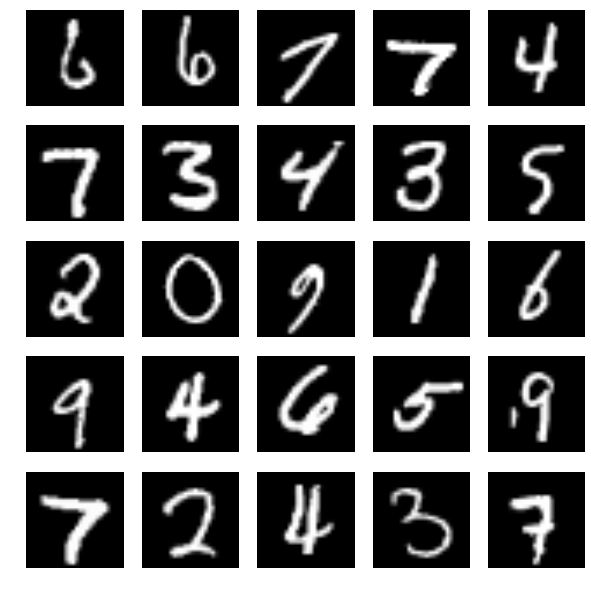

In [12]:
input_images = scaler.inverse_transform(X.reshape(flat_shape)).reshape(image_shape)
input_images_ = input_images.transpose((0, 2, 3, 1))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
fig = plt.figure(figsize=(10, 10))
n = 5
gridw, gridh = n, n
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

# Model

In [13]:
class Model(object):
    def __init__(self):
        self.extra_params = []
    def get_all_params(self, **kwargs):
        return (list(set(self.x_to_z.get_all_params(**kwargs) + 
                        self.z_to_x.get_all_params(**kwargs)))+self.extra_params)

In [14]:
model_type = "fully_connected"

In [15]:
from lasagne import init
def quantile_standard(p=0.5):
    return np.sqrt(2) * T.erfinv(2*p-1)

def quantile(x, p=0.5, axis=None):
    return x.mean(axis=axis) + x.std(axis=axis) * quantile_standard(p)

def thresh_for(x, keep=100):
    return T.addbroadcast((T.sort(x, axis=1)[:, -keep:-keep+1]), 1)

if model_type == "fully_connected":
    ## fully connected
    latent_size = 2000
    keep = theano.shared(np.array(70))
    temperature = theano.shared(np.array(1.).astype(np.float32))
    l_in = layers.InputLayer((None, nb_colors, w, h), name="input")
    l_pre_latent = layers.DenseLayer(l_in, 
                                 num_units=latent_size,
                                 name="latent",
                                 #W=init.Normal(std=0.01),
                                 #W=init.Uniform(range=0.01),
                                 W=init.Uniform(range=0.27),
                                 #nonlinearity=T.nnet.sigmoid,
                                 #nonlinearity=rectify,
                                 nonlinearity=None,
                                 #nonlinearity=lambda x:rectify(x+thresh)* (x/(x+thresh)),
                                 #b=Constant(0.),
                                 b=None
                                 )
    l_latent = SampleOutLayer(l_pre_latent, temperature=temperature)
    #l_latent = layers.NonLinearityLayer(l_pre_latent, 
    #                                    lambda x: (x>   thresh_for(x, keep=keep)  )*x)
    l_decoder_out = TransposedDenseLayer(l_latent, num_units=nb_colors*w*h,
                                         W=l_pre_latent.W,
                                         #W=init.Uniform(range=0.2734344),
                                         b=Constant(0.),
                                         nonlinearity=None)
    l_decoder_out_reshaped = layers.ReshapeLayer(l_decoder_out, ([0], nb_colors, w, h))
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out_reshaped])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
    #model.extra_params.append(thresh)

In [16]:
def show_filters(all_layers, shuffled=True, nbrows=10, nbcols=10, scaler=None):
    fig = plt.figure(figsize=(10, 10))
    V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
    V = V.T
    if scaler is not None:
        V = scaler.inverse_transform(V)
    V = V.reshape((-1, nb_colors, w, h))
    #min_val = V.min(axis=(0, 2, 3))[np.newaxis, :, np.newaxis, np.newaxis]
    #max_val = V.max(axis=(0, 2, 3))[np.newaxis, :, np.newaxis, np.newaxis]
    min_val = V.min(axis=0)
    max_val = V.max(axis=0)
    V = (V - min_val) / (max_val - min_val)

    V = V.transpose((0, 2, 3, 1)) 
    V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
    s = np.arange(V_.shape[0])
    np.random.shuffle(s)
    grid_plot(V_[s, :, :], imshow_options={"cmap": "gray"}, nbrows=nbrows, nbcols=nbcols)
    plt.show()

In [17]:
if model_type == "convnet":
    filter_size = 5
    latent_size = 50
    num_filters = 64
    
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, 
                                filter_size=(filter_size, filter_size),
                                name="conv1")
    l_conv_2 = layers.Conv2DLayer(l_conv, num_filters=num_filters, 
                                  filter_size=(filter_size, filter_size),
                                  name="conv2")
    sw = w - 2 * filter_size + 2
    l_latent = Conv2DDenseLayer(l_conv_2, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    
    l_unconv_2 = layers.Conv2DLayer(l_un_latent, num_filters=num_filters, 
                                   filter_size=(filter_size, filter_size),
                                   pad="full",
                                   name="unconv_2")
    l_unconv = layers.Conv2DLayer(l_unconv_2, num_filters=nb_colors, 
                                  filter_size=(filter_size, filter_size),
                                  pad="full",
                                  name="unconv_1")

    l_decoder_out = l_unconv
    
    """
    l_in = layers.InputLayer((None, nb_colors, None, None), name="input")    
    l_conv = layers.Conv2DLayer(l_in, num_filters=num_filters, filter_size=(filter_size, filter_size), name="conv1")
    
    l_pool = layers.Pool2DLayer(l_conv, pool_size=(2, 2), name="pool1")
    #l_pool = l_conv
    
    # sw = (w - filter_size + 1)
    sw = (w - filter_size + 1) / 2

    l_latent = Conv2DDenseLayer(l_pool, 
                                num_units=latent_size,
                                name="latent",
                                nonlinearity=None,# linear    
                                filter_size=(sw, sw))
                                
    l_un_latent = layers.Conv2DLayer(l_latent, 
                                     num_filters=num_filters,
                                     filter_size=(sw, sw), 
                                     pad='full',
                                     name="un_latent")
    
    l_unpool = layers.Upscale2DLayer(l_un_latent, 2, name="unpool1")
    #l_unpool = l_un_latent
    l_unconv = layers.Conv2DLayer(l_unpool, num_filters=nb_colors, 
                                  filter_size=(filter_size, filter_size),
                                  #W=l_conv.W,
                                  name="unconv1",
                                  pad='full',
                                  nonlinearity=None)
    l_decoder_out = l_unconv
    """
    print(layers.get_output_shape(l_decoder_out, (100, 3, 28, 28)))
    x_to_z = LightweightModel([l_in], [l_latent])
    z_to_x = LightweightModel([l_latent], [l_decoder_out])
    model = Model()
    model.x_to_z = x_to_z
    model.z_to_x = z_to_x
    
    
    def show_filters(all_layers, shuffle=True, nbrows=10, nbcols=10):
        
        fig = plt.figure(figsize=(10, 10))
        V = all_layers[1].W.get_value() #> all_layers[1].b.get_value()[:, None, None, None]
        V = V.transpose((0, 2, 3, 1)) 
        min_val = V.min(axis=(1, 2, 3))[:, None, None, None]
        max_val = V.max(axis=(1, 2, 3))[:, None, None, None]
        V = (V - min_val) / (max_val - min_val)
        V_ = V[:, :, :, 0] if V.shape[-1] == 1 else V
        s = np.arange(V_.shape[0])
        if shuffle is True:
            np.random.shuffle(s)
        grid_plot(V_[s], imshow_options={"cmap": "gray"}, nbrows=nbrows, nbcols=nbcols)
        plt.show()

In [18]:
layers_by_name = OrderedDict()


all_layers = (
    layers.get_all_layers(model.x_to_z.output_layers[0]) +
    layers.get_all_layers(model.z_to_x.output_layers[0])
)

for l in all_layers:
    if l.name is not None:
        layers_by_name[l.name] = l
print(layers_by_name.keys())

['input', 'latent']


## Define the capsule object

The Capsule object combines all the components:

    - The model
    - The training algorithm
    - The loss function

In [19]:
input_variables = OrderedDict()
input_variables["input_image"] = dict(tensor_type=T.tensor4)

In [285]:
def loss_function(model, tensors, noise=False):
    input_image = tensors["input_image"]    
    input_image_old = input_image
    #noisify
    if noise is True:
        print(noise)
        #input_image = input_image * (rng.uniform(size=input_image.shape) <= 0.7)
        input_image = input_image + rng.normal(std=0.01, size=input_image.shape)
    output = get_output(model, input_image)    
    #recons = ((input_image_old - output) ** 2)
    recons = (input_image_old * T.nnet.softplus(-output) + (1 - input_image_old) * T.nnet.softplus(output))
    recons = recons.sum(axis=(1, 2, 3))
    return recons.mean()

def get_latent(model, input_image):
    z, = model.x_to_z.get_output(input_image)
    return z

def get_pre_latent(model, input_image):
    return layers.get_output(l_pre_latent, input_image)

def get_output(model, input_image):
    z = get_latent(model, input_image)
    o, = model.z_to_x.get_output(z)
    return o

def get_output_from_latent(model, latent):
    o, = model.z_to_x.get_output(latent)
    return o

def get_loss(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=True)

def get_loss_deterministic(model, input_image):
    return loss_function(model, {"input_image": input_image}, noise=False)

functions = dict(
    get_output=dict(
        get_output=get_output,
        params=["input_image"]
    ),   
    get_latent=dict(
        get_output=get_latent,
        params=["input_image"]
    ),
    get_pre_latent=dict(
        get_output=get_pre_latent,
        params=["input_image"]
    ),
    get_loss=dict(
        get_output=get_loss,
        params=["input_image"]
    ),
    get_loss_deterministic=dict(
        get_output=get_loss_deterministic,
        params=["input_image"]
    )
    
  
)

class MyBatchOptimizer(BatchOptimizer):
    # called for each epoch during training
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        nb = 200
        status["train_loss"] = self.model.get_loss_deterministic(X[train][0:nb])
        status["test_loss"] = self.model.get_loss_deterministic(X[test][0:nb])

        if (status["epoch"] % 10) == 0:
            show_filters(all_layers, scaler=scaler)
        keep.set_value( max(keep.get_value()-1, 40)  )
        
        V = max(10 + (float(1 - 10) / 50) * status["epoch"], 1)
        temperature.set_value((np.array(V).astype(np.float32)))
        print(temperature.get_value())
        return status

In [286]:
#re-init
l_pre_latent.W.set_value(init.Orthogonal()(l_pre_latent.W.get_value().shape))
l_decoder_out.b.set_value(init.Constant(0.)(l_decoder_out.b.get_value().shape))
keep.set_value(40)
temperature.set_value(10)

In [287]:
batch_optimizer = MyBatchOptimizer(
    max_nb_epochs=200,
    verbose=1,
    batch_size=128,
    #optimization_procedure=(updates.adam, {"learning_rate": 0.001})
    #optimization_procedure=(updates.momentum, {"learning_rate": 0.0001, "momentum": 0.5})
    optimization_procedure=(updates.rmsprop, {"learning_rate": 0.0001})
)

In [288]:
capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)

True


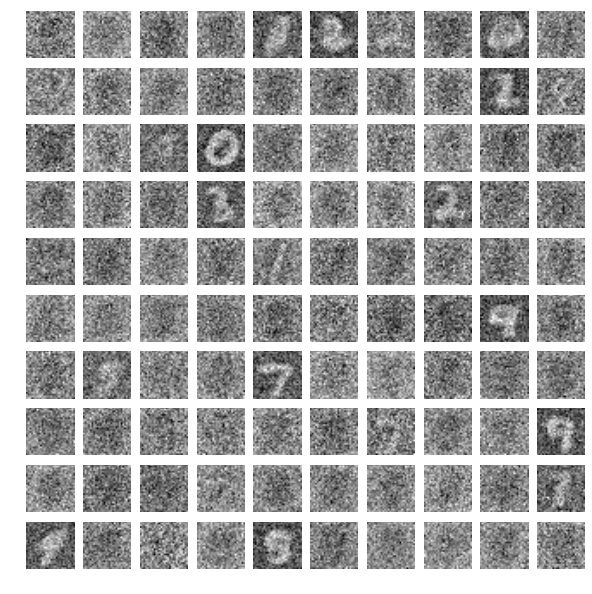

10.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      0     47.8033       463.152       379.946      390.967
9.81999969482
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      1     22.8625           344        307.58      310.104
9.64000034332
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      2     14.8339       283.277       262.405      266.749
9.46000003815
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      3      11.796       242.328       227.148       225.15
9.27999973297
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
      4     9.12153       210.866       203.559      196.658
9.10000038147
  epoch   

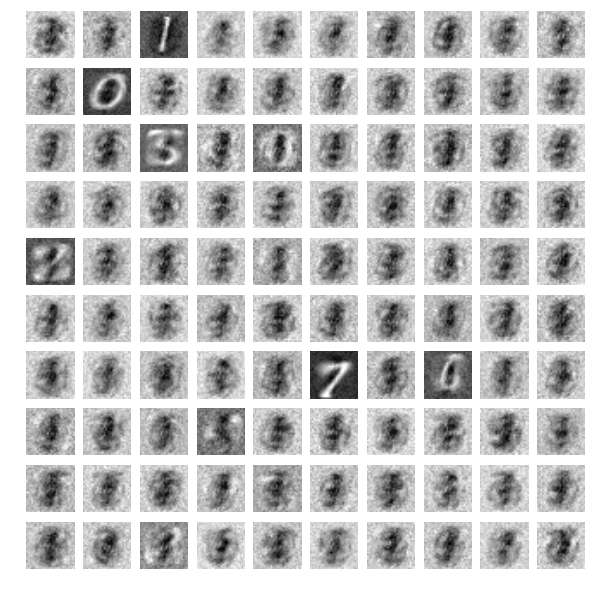

8.19999980927
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     10      6.2892       132.499        133.48      143.784
8.02000045776
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     11     7.97277       130.798       132.454        138.2
7.84000015259
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     12      8.6737       130.034       133.912      141.277
7.65999984741
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     13     9.82436       129.982       130.074      134.819
7.48000001907
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     14     10.7229       130.483       124.455      143.763
7.30000019073
 

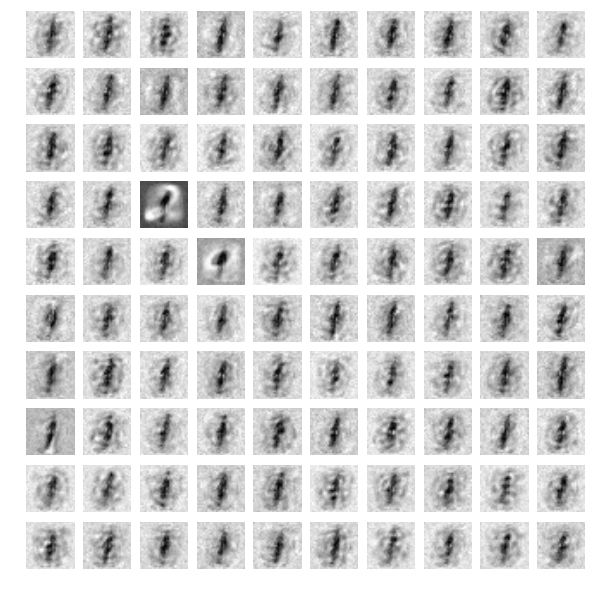

6.40000009537
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     20     10.1391       114.089       109.138       131.03
6.21999979019
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     21     9.11794       110.269       104.391      126.226
6.03999996185
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     22     8.88542       107.402       98.4657      127.542
5.86000013351
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     23     7.95897       104.411       103.104       116.42
5.67999982834
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     24     7.96188       101.667       98.1668      115.063
5.5
  epoch    

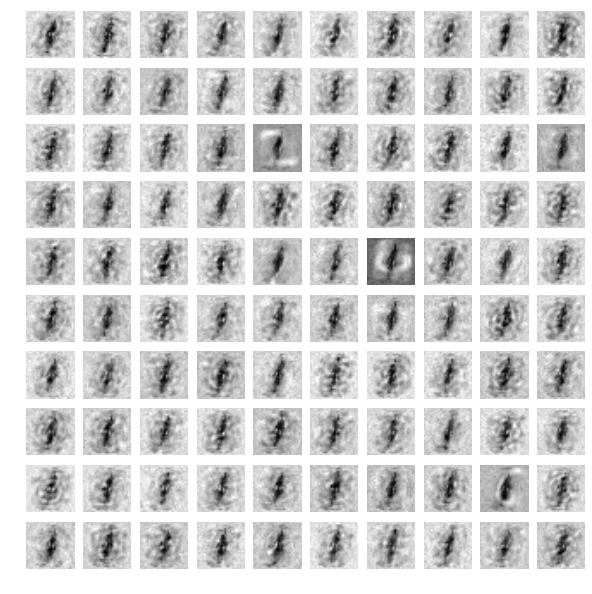

4.59999990463
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     30     8.68377       94.4311       88.1503      114.608
4.42000007629
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     31     9.46754       93.3313       88.4041      111.277
4.23999977112
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     32     8.20477       91.8643        87.214        116.1
4.05999994278
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     33     10.2413        93.106       89.3724       114.45
3.88000011444
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     34     10.8131       95.4237       97.1954      124.461
3.70000004768
 

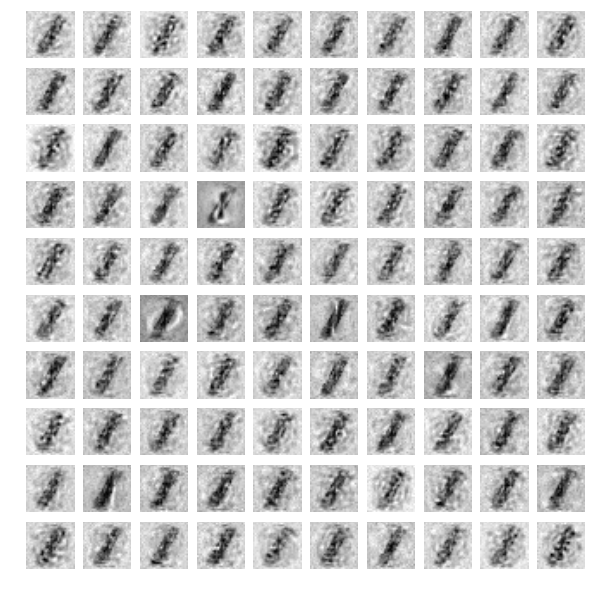

2.79999995232
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     40     5.32336       81.9003       80.5597      108.841
2.61999988556
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     41     5.45515        79.269       77.2193      103.233
2.44000005722
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     42     5.01858       76.7494       75.4429      98.4316
2.25999999046
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     43     4.31238       74.5468       73.5797      107.072
2.07999992371
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     44     4.48659       72.9661        71.956      100.669
1.89999997616
 

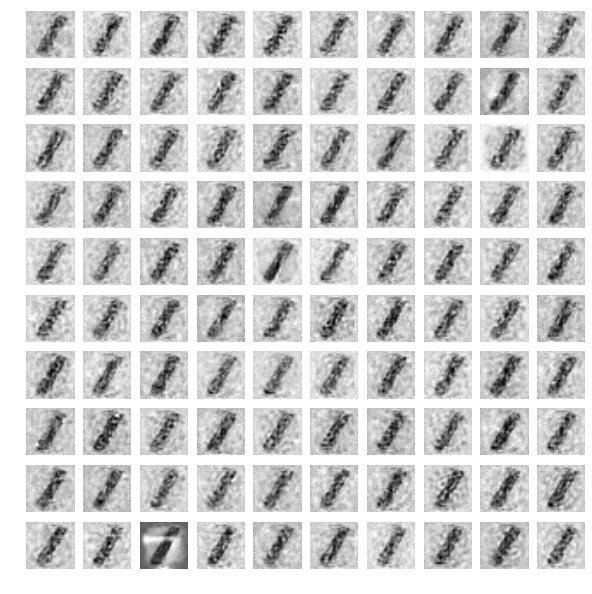

1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     50     2.98118       63.7583        63.389      85.4195
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     51     2.59172        62.393       62.2966      77.4544
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     52     2.41097       61.7616       61.7709      76.1216
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     53     2.41243       61.2336       61.1911      73.8683
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     54     1.86301       60.7265       60.8762      70.8313
1.0
  epoch    loss_std    loss_train    train_loss    test_loss


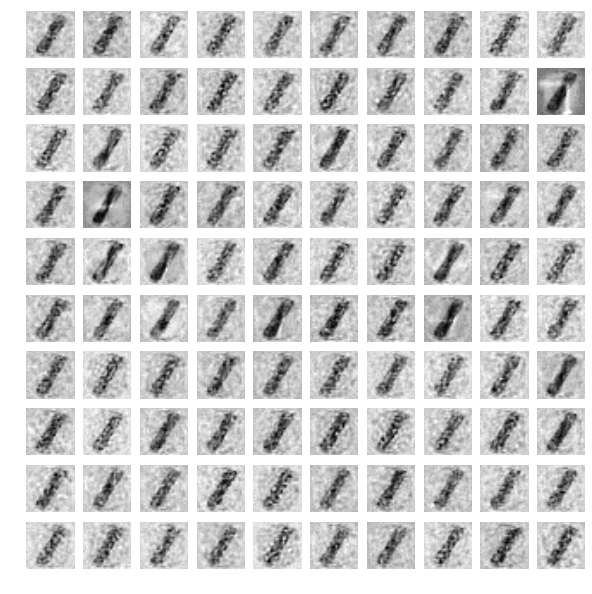

1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     60     1.26066       58.7593        59.263        69.48
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     61     1.30564       58.5453       59.0832      69.6108
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     62     1.17433       58.2852       59.0836      66.8394
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     63     1.13196       58.1352       59.0282         66.1
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     64      1.1895       57.9644       58.7456      67.2951
1.0
  epoch    loss_std    loss_train    train_loss    test_loss


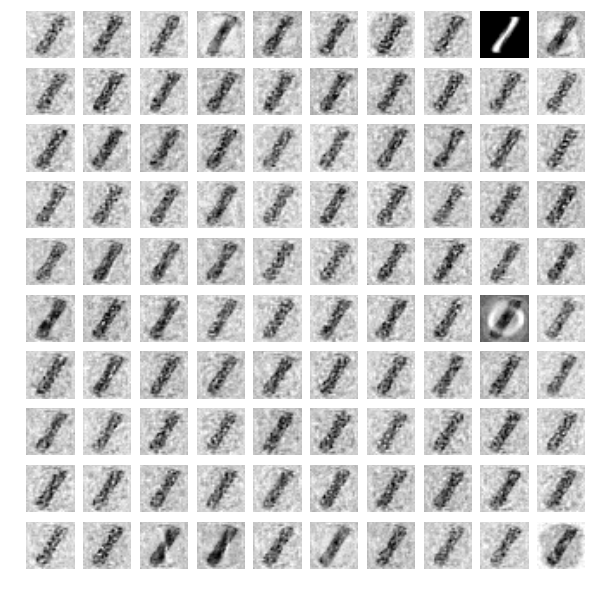

1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     70     1.03542       57.3461       58.2959      64.2032
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     71     1.05005       57.3172       58.4899      63.9843
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     72     1.01808       57.2619       58.3925       61.914
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     73     1.03014       57.2296       58.6012      65.4907
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     74     1.03543       57.2019       58.3131      60.9365
1.0
  epoch    loss_std    loss_train    train_loss    test_loss


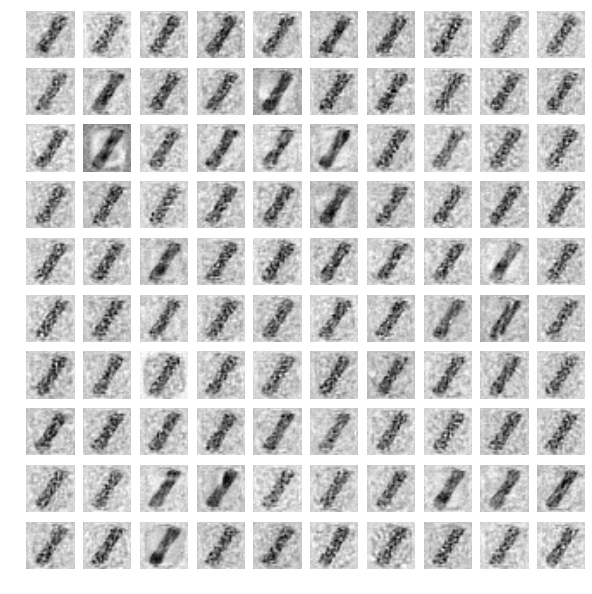

1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     80     1.01315       56.9826       57.7612      62.0411
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     81      1.0057       56.9531       57.9257      60.3382
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     82    0.990725       56.8616       57.6203      61.4414
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     83    0.991924       56.8244        57.633      61.5301
1.0
  epoch    loss_std    loss_train    train_loss    test_loss
-------  ----------  ------------  ------------  -----------
     84    0.994351       56.7872       57.7208      61.6604
1.0
  epoch    loss_std    loss_train    train_loss    test_loss


KeyboardInterrupt: 

In [289]:
%%time
capsule.fit(input_image=X[train])

In [273]:
h=(capsule.get_pre_latent(X[0:1]))
h=(h-h.min())/(h.max()-h.min())
h=h**6
print( (np.random.uniform(size=h.shape)<=h).sum())
w,h=28,28

1


## checking performance

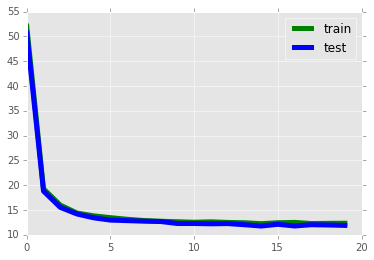

In [274]:
from lasagnekit.easy import get_stat
plt.plot(get_stat("train_loss", batch_optimizer.stats), c='g', label="train", linewidth=5)
plt.plot(get_stat("test_loss", batch_optimizer.stats), c='b', label="test", linewidth=5)
plt.legend()
plt.show()

In [275]:
input_images = X
input_images = input_images[np.random.randint(0, input_images.shape[0], size=150)]
output_images = capsule.get_output(input_images)

In [276]:
print(input_images.shape)

(150, 1, 28, 28)


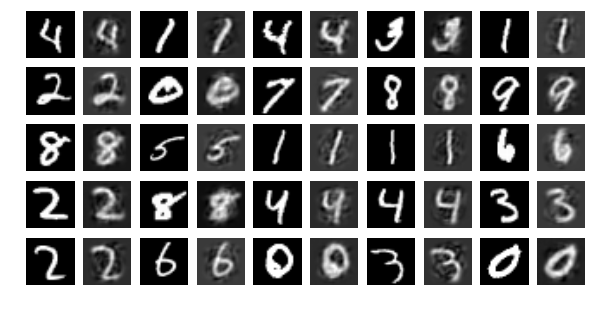

In [277]:
input_images_ = deprocess(input_images).transpose((0, 2, 3, 1))

def a(x):
    return x
    return 1./(1.+np.exp(-x))
output_images_ = a(deprocess(output_images).transpose((0, 2, 3, 1)))

if input_images_.shape[-1] == 1:
    input_images_ = input_images_[:, :, :, 0]
    
if output_images_.shape[-1] == 1:
    output_images_ = output_images_[:, :, :, 0]

input_images_ = input_images_[0:n**2]
fig = plt.figure(figsize=(10, 10))
n = 5

gridw, gridh = n*2, n*2
k = 1
ind = 0
for i in range(n):
    for j in range(n):
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(input_images_[ind], cmap="gray")
        k += 1
        plt.subplot(gridw, gridh, k)
        plt.axis('off')
        plt.imshow(output_images_[ind], cmap="gray")
        k += 1
        ind += 1
plt.show()

## Apply blending

In [ ]:
#!wget http://i.imgur.com/2HVJF0t.gif --output-document=image.gif
#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/cheval%201/images/chevaux_1_015.gif --output-document=image.gif

!wget http://i.imgur.com/iqZBF6A.jpg --output-document=image.jpg # im1
#!wget http://jmg.j.m.pic.centerblog.net/it3ahbzg.jpg --output-document=image.jpg #im2
#!wget http://jmg.j.m.pic.centerblog.net/c4j703bp.jpg --output-document=image.jpg #im3
#!wget http://www.freelargeimages.com/wp-content/uploads/2014/12/Landscape_01.jpg --output-document=image.jpg # im4

#!wget http://www.mescoloriages.com/coloriages/animaux/cheval/chevaux%205/images/chevaux_5_008.gif --output-document=image.gif
#!wget http://www2.mes-coloriages-preferes.biz/colorino/Images/Large/Animaux-Cheval-3756.png --output-document=image.gif
#!wget https://sustainability.uic.edu/files/2013/11/Tree.jpg --output-document=image.jpg --no-check-certificate
#!wget http://www.vbctulsa.com/wordpress/wp-content/uploads/2015/02/wrackthetree.jpg --output-document=image.jpg

In [ ]:
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
image = (imread("image.jpg"))
print(image.shape)
image = resize(image, (256, 256))
#image = image[:, :, 0] # RGB?
#print(image)
image = 1 - image
if len(image.shape) == 2:
    image = image[:, :, None] * np.ones((1, 1, nb_colors))
print(image.shape)

In [ ]:
fig = plt.figure(figsize=(5, 5))
im = image[:, :, 0] if nb_colors == 1 else image
orig_im = im.copy()
plt.imshow(1-im, cmap="gray")

In [ ]:
image_ = (image.transpose((2, 0, 1)).astype(np.float32))[None, :, :, :].copy()
image_ = preprocess(image_)
print(image_.shape)
for i in range(1):
    image_ = capsule.get_output(image_)
image_ = deprocess(image_)
image__ = image_.transpose((0, 2, 3, 1))

im = image__[0, :, :, 0] if nb_colors == 1 else image__[0]

alpha=0.03
im = (im - im.min()) / (im.max() - im.min())
fig = plt.figure(figsize=(5, 5))
plt.imshow( (1-im), cmap="gray")

## weights

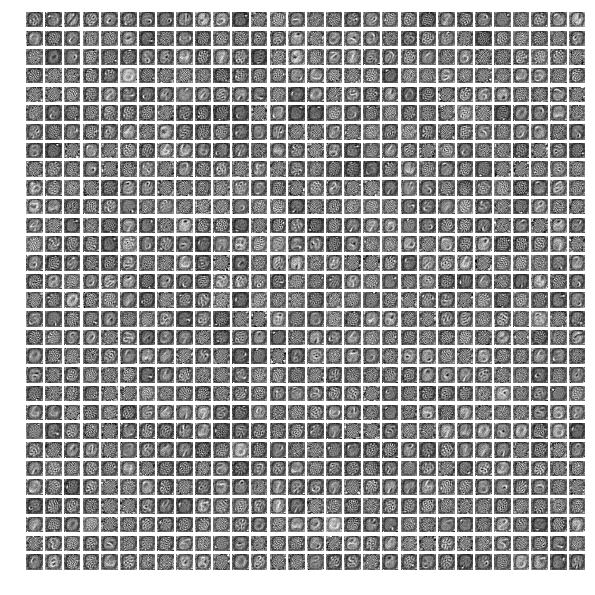

In [106]:
show_filters(all_layers, nbrows=30, nbcols=30)